In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os


INPUT_DIR = "input/UD_English-EWT"
OUTPUT_DIR = "output"
INTERMEDIATE_DIR = "intermediate"

## Dataset

Acquiring and preprocessing our data with the goal of eventually acquiring a sufficient representation of our text is the most difficult and time-consuming task. We thus split it in distinct phases:

* Original dataset acquisition and parsing
* Qualitative analysis and preprocessing
* Transformation for the NLP task

Note that due to the relative custom code complexity, most of the code used in this section was developed and imported from python source files located in the `tasks` module. In-depth documentation and implementation details can be found in these files. 

### Acquisition

We select the [English EWT-UD](https://universaldependencies.org/treebanks/en_ewt/index.html) tree, which is the largest currently supported collection for POS tagging tasks for the English task.

This corpus contains 16622 sentences, 251492 tokens and 254820 syntactic words, as well as 926 types of words that contain both letters and punctuation, such as 's, n't, e-mail, Mr., ’s, etc). This is marketly a much higher occurence than its siblings, and therefore may lead to a slightly more difficult task.

The dataset is made available in `conllu` format, which we parse using the recommended `conllu` python library (see tasks.preprocessing for more details). We create a dataframe for every word and its corresponding POS tag and link words belonging to the same sentences by a unique sentence ID. The data are already split to training, validation and test sets, thus our own sets correspond to the respective split files.

We are interested in the UPOS (Universal Part of Speech) tags for English words. The only meaningful preprocessing at this stage thus would be converting the words to lowercase. We believe that the context of each word will carry enough information to distinguish its POS tag regardless of case.

In [2]:
import tasks.common
from tasks import preprocessing

In [3]:
print("Loading training dataset...")
train_df = preprocessing.conllu_to_pd(os.path.join(INPUT_DIR, "en_ewt-ud-train.conllu"))
print("Loading validation dataset...")
val_df = preprocessing.conllu_to_pd(os.path.join(INPUT_DIR, "en_ewt-ud-dev.conllu"))
print("Loading test dataset...")
test_df = preprocessing.conllu_to_pd(os.path.join(INPUT_DIR, "en_ewt-ud-test.conllu"))

print(f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}\nTest data shape: {test_df.shape}")

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2001 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2077 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (25511, 3)
Test data shape: (25450, 3)


Below we can see a preview of our parsed training dataset. Our preprocessing exploits pandas's ordering scheme in order to make sure the words are inserted in the order they appear in the sentence. This ordering will prove important later.

In [4]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


As mentioned above, our dataset features words connected with punctuation such as "don't". These are normally treated as two words, with the first being their intuitive POS tag ("do" - AUX) and the second as part of the first ("n't" - PART).

This dataset contains both the full words and their split versions, with only the latter featuring valid POS tags. The former are instead marked by a pseudo-tag (here "_").

In [5]:
invalid_idx = train_df.pos == "_"
train_df[invalid_idx]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
704,won't,_,weblog-juancole.com_juancole_20051126063000_EN...
868,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1058,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1078,doesn't,_,weblog-blogspot.com_healingiraq_20040409053012...
...,...,...,...
207078,couldn't,_,reviews-319816-0025
207091,don't,_,reviews-319816-0025
207096,employees',_,reviews-319816-0025
207164,i'm,_,reviews-319816-0027


In [6]:
" ".join(train_df[invalid_idx].words.unique()[:30])

"don't won't doesn't haven't didn't others it's elena's women's children's i'm people's musharraf's sharon's hamas's right's cannot isn't one's let's reporter's he's that's pakistan's world's bush's military's sharif's can't couldn't"

Below we can see an example of a word being contained both times in the dataset, one in full with the pseudo-tag, and the other as split words with valid POS tags.

In [7]:
train_df.iloc[176:179]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
177,do,AUX,weblog-juancole.com_juancole_20051126063000_EN...
178,n't,PART,weblog-juancole.com_juancole_20051126063000_EN...


We thus remove the full words including the pseudo-tag from our datasets, ensuring that all target POS tags will be compliant with the UPOS scheme.

In [8]:
train_df = train_df[~invalid_idx]
val_df = val_df[val_df.pos != "_"]
test_df = test_df[test_df.pos != "_"]

### Qualitative Analysis

We analyze our dataset in two granualities: sentences and individual words. We begin by analyzing how many words are in each sentence, which will give us an idea on the size of context available for each word.

In [9]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words


train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

FileNotFoundError: [Errno 2] No such file or directory: 'output/output/ex_10_dataset_stats.png'

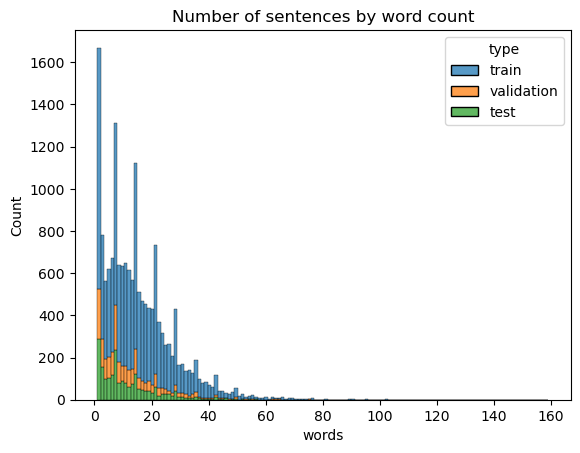

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
tasks.common.save_plot("ex_10_dataset_stats", OUTPUT_DIR)
plt.show()

We can also get some summary statistics about our individual data splits:

In [ ]:
train_length.describe()

In [ ]:
val_length.describe()

In [ ]:
test_length.describe()

The total word count is also important since our model will fundementally operate on individual words and their immediate context:

In [ ]:
print(f"Vocabulary size: {len(set(train_df.words))}")

In [ ]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

In [ ]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

### Qualitative preprocessing

From the figure above we can infer that there is a substantial amount of very small paragraphs. Since we do not desire to train our model on words with little to no immediate context, we can remove sentences with shorter than a critical length.

In [ ]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [ ]:
MIN_SENTENCE_LENGTH = 5

train_df_filt = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df_filt = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df_filt = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_df_filt

### Transforming the data

For the final pre-processing step we need to acquire window embeddings for the words in our dataset. 

### The embedding model

We use a Word2Vec variant implemented in the `spacy` library called `en_core_web_md`. The model is suitable for our needs because of the similarities in domain (pre-trained on blogs, news and comments which fits our dataset). It's also the largest offered by spacy, with a total size of 1GB.

In [ ]:
print("Downloading Word2Vec model...")

In [ ]:
%%capture
!python -m spacy download en_core_web_md

In [ ]:
print("Model downloaded.")

In [ ]:
import spacy


print("Loading Word2Vec model...")
word2vec = spacy.load('en_core_web_md')
print("Model loaded.")

Because of the model's size and the abundance of data in our dataset, we cache our computations into local `numpy` files, as the calculations can take up to an hour to complete.

In [ ]:
def save_global_state(x_train, x_valid, x_test, y_train, y_valid, y_test):
    np.save(os.path.join(INTERMEDIATE_DIR, "x_train.npy"), x_train)
    np.save(os.path.join(INTERMEDIATE_DIR, "x_valid.npy"), x_valid)
    np.save(os.path.join(INTERMEDIATE_DIR, "x_test.npy"), x_test)

    np.save(os.path.join(INTERMEDIATE_DIR, "y_train.npy"), y_train)
    np.save(os.path.join(INTERMEDIATE_DIR, "y_valid.npy"), y_valid)
    np.save(os.path.join(INTERMEDIATE_DIR, "y_test.npy"), y_test)


def load_global_state():
    x_train = np.load(os.path.join(INTERMEDIATE_DIR, "x_train.npy"))
    x_valid = np.load(os.path.join(INTERMEDIATE_DIR, "x_valid.npy"))
    x_test = np.load(os.path.join(INTERMEDIATE_DIR, "x_test.npy"))

    y_train = np.load(os.path.join(INTERMEDIATE_DIR, "y_train.npy"))
    y_valid = np.load(os.path.join(INTERMEDIATE_DIR, "y_valid.npy"))
    y_test = np.load(os.path.join(INTERMEDIATE_DIR, "y_test.npy"))
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

### Window Embedding creation

The custom code used for this task can be found in the `tasks.preprocessing` module. In short we perform the following operations:

* For each word in a sentence, acquire a window of size $k$ (here 5). Include right and left padding for the $floor(k/2)$ first and last words of the sentence.
* For each window acquire the target (POS tag) of the median word.
* For each window up to a limit, acquire the window embedding by concantenating the word vectors of each word.

We choose a padding embedding of all-zeros. Although the mathematical significance of this strategy is minimal (because of the bias term in the first dense layer always potentially yielding non-zero results to the activation function), it ensures the padding embedding is distinct from actual word embeddings. In any case, our classifier should learn to discard pad tokens by itself.

The design of our input procedure ensures that no padding output token will at any circumstance occur, thus we need not create a pseudo-output token for it.

Our final data is composed of 100,000 window embeddings, distributed in a 65-25-10%  train-validation-test split. We reserve a relatively large validation set because of the extensive hyper-parameter search which we perform later.

In [ ]:
from sklearn.preprocessing import LabelBinarizer


try:
    print("Attempting to load intermediate calculations...")
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_global_state()
except FileNotFoundError:
    print("No intermediate files present, calculating from scratch.")
    
    WINDOW_SIZE = 5
    
    lb = LabelBinarizer()

    print("Processing training dataset...")
    x_train, y_train = preprocessing.preprocess(
                            train_df_filt, WINDOW_SIZE, 65000, word2vec, lb, train_binarizer=True)
    
    print("Processing validation dataset...")
    x_valid, y_valid = preprocessing.preprocess(
                            val_df_filt, WINDOW_SIZE, 25000, word2vec, lb)
    
    print("Processing test dataset...")
    x_test, y_test = preprocessing.preprocess(
                            test_df_filt, WINDOW_SIZE, 10000, word2vec, lb)

    print("Saving processed datasets...")
    save_global_state(x_train, x_valid, x_test, y_train, y_valid, y_test)
    

x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape,

## Baseline Classifier

We create our own classifier which classifies each token by the majority label associated with it. The classifier is defined as a subclass of sklearn's classifier superclass and thus can seamlessly use it in most sklearn-provided functions such as `classification_report()`.

In [ ]:
from tasks.models import BaselineLabelClassifier


base_cls = BaselineLabelClassifier()
base_cls.fit(X=train_df_filt.words, y=train_df_filt.pos)

We acquire training and test statistics which will serve as a baseline for our NLP model, quantifying how much of an improvement we reach over the simplest "intelligent" classification scheme possible for our task.

In [ ]:
from sklearn.metrics import classification_report


training_preds = base_cls.predict(train_df_filt.words)
print(classification_report(train_df_filt.pos, training_preds))

In [ ]:
test_preds = base_cls.predict(test_df_filt.words)
print(classification_report(test_df_filt.pos, test_preds))

Note how even a comparatively "dumb" majority classifier which simply memorizes the occurences of tag by word performs decently well with a 83% test F1-score. This makes intuitive sense, since many words such as "the" or "a" have a well-defined role in the English language which is invariant to context.

## MLP Classifier

We now design a MLP classifier which takes as input the (possibly padded) window embedding of a word, and returns its POS tag as output.

In [ ]:
import time
import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print("Executing with ", gpus[0].name if len(gpus) != 0 else "CPU")

### Hyper-parameter search

We will be using the `keras_tuner` library to automatically perform random search over various hyper-parameters of our model.

The parameter search consists of:
* The depth of the model (the number of layers)
* The height of the model (the number of parameters by layer)
* The learning rate

The parameter search does NOT consist of:
* Dropout rate, since dropout rarely changes the final result of a neural network, but rather tunes the tradeoff between training time and overfit avoidance
* Activation functions, since they rarely significantly influence the model's performance

With this scheme we hope to maximize the area and granuality of our search to the hyper-parameters that are most likely to significantly influence the final results.

We implement early stopping and set a maximum iteration limit of $70$. We assume that if a model needs to go over that limit, it may be computationally inefficient, and thus less desirable compared to a slightly worse, but much more efficient model.

In [ ]:
# code adapted from Foivos Charalampakos
def search_mlp_model(hp, input_size: int, output_size: int, min_hid_size: int, max_hid_size: int):
    model = Sequential()

    layer_index = 0
    for i in range(hp.Int(name='num_layers', min_value=1, max_value=4)):
        if layer_index == 0:
            # first layer
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),
                                   min_value=min_hid_size,
                                   max_value=max_hid_size,
                                   step=256),
                            activation="relu",
                            input_dim=input_size
                           ))
            model.add(Dropout(0.5))
        else:
            # subsequent layer
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),
                                   min_value=min_hid_size,
                                   max_value=max_hid_size,
                                   step=256),
                            activation="relu"))
            model.add(Dropout(0.5))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(Dense(output_size,  activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=[CategoricalAccuracy()])

    return model

Just like before, we cache our results in a dedicated directory, so we have to perform the search only once.

In [ ]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping


tuner = kt.RandomSearch(lambda x: search_mlp_model(x,
                                                    input_size=x_train.shape[1],
                                                    output_size=y_train.shape[1],
                                                    min_hid_size=128,
                                                    max_hid_size=2048),
                        objective=kt.Objective('val_categorical_accuracy',
                                               direction='max'),
                        max_trials=25,
                        directory='KT_dir',
                        project_name='KT_pos')

early_stopping = EarlyStopping(monitor='val_loss', patience=8)
tuner.search_space_summary()

In [ ]:
tuner.search(x_train,
             y_train,
             validation_data=(x_valid, y_valid), 
             epochs=70, 
             batch_size=256,
             callbacks=[early_stopping])

In [ ]:
# Get best hyper-parameters setup
tuner.get_best_hyperparameters()[0].values

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
best_model.save(os.path.join(INTERMEDIATE_DIR, "optimal_model.keras"))